## Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

import model_metrics

print(model_metrics.__version__)

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from model_tuner import Model, loadObjects
import model_tuner

from ucimlrepo import fetch_ucirepo
from eda_toolkit import ensure_directory
from sklearn.metrics import roc_curve
from model_metrics import (
    summarize_model_performance,
    show_calibration_curve,
    show_confusion_matrix,
    show_roc_curve,
    show_feat_roc,
    show_feat_pr,
    show_pr_curve,
    show_lift_chart,
    show_gain_chart,
    show_ks_curve,
    plot_threshold_metrics,
)

0.0.2a


## Set Model Path

In [2]:
print(f"Model Metrics version: {model_metrics.__version__}")
print(f"Model Metrics authors: {model_metrics.__author__} \n")

## Define base paths
## `base_path`` represents the parent directory of your current working directory
base_path = os.path.join(os.pardir)
## Go up one level from 'notebooks' to the parent directory, then into the
## 'results' folder

model_path = os.path.join(os.pardir, "model_files/results")
data_path = os.path.join(os.pardir, "model_files")
image_path_png = os.path.join(data_path, "images", "png_images")
image_path_svg = os.path.join(data_path, "images", "svg_images")

# Use the function to ensure the 'data' directory exists
ensure_directory(model_path)
ensure_directory(image_path_png)
ensure_directory(image_path_svg)

Model Metrics version: 0.0.2a
Model Metrics authors: Leonid Shpaner 

Directory exists: ../model_files/results
Directory exists: ../model_files/images/png_images
Directory exists: ../model_files/images/svg_images


## Load The Model Object and Test Data

In [3]:
adult = fetch_ucirepo(id=2)

# data (as pandas dataframes)
X = adult.data.features

In [4]:
model_lr = loadObjects(os.path.join(model_path, "LogisticRegression.pkl"))
model_dt = loadObjects(os.path.join(model_path, "DecisionTreeClassifier.pkl"))
model_rf = loadObjects(os.path.join(model_path, "RandomForestClassifier.pkl"))


X_test = pd.read_parquet(os.path.join(data_path, "X_test.parquet"))
y_test = pd.read_parquet(os.path.join(data_path, "y_test.parquet"))

Object loaded!
Object loaded!
Object loaded!


In [5]:
X

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States
48838,64,NaN,321403,HS-grad,9,Widowed,NaN,Other-relative,Black,Male,0,0,40,United-States
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States


In [6]:
X_test_2 = X_test.join(
    X[["sex", "race", "relationship", "occupation", "workclass", "education"]]
)

In [7]:
X_test_2

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,sex,race,relationship,occupation,workclass,education
index,,,,,,,,,,,,
4384,27,181667,9,5013,0,46,Male,White,Husband,Machine-op-inspct,Private,HS-grad
16656,51,171409,10,0,0,40,Male,White,Husband,Transport-moving,Private,Some-college
22898,84,127184,3,0,0,20,Male,White,Husband,?,?,5th-6th
15632,60,40856,11,0,0,46,Male,White,Husband,Craft-repair,Private,Assoc-voc
2301,45,158685,9,0,0,40,Female,White,Not-in-family,Sales,Private,HS-grad
...,...,...,...,...,...,...,...,...,...,...,...,...
32955,41,155041,9,3418,0,40,Female,White,Own-child,NaN,NaN,HS-grad
36943,58,115439,14,0,0,40,Male,White,Husband,Sales,Self-emp-not-inc,Masters
40470,42,276218,13,0,0,38,Female,White,Unmarried,Exec-managerial,Private,Bachelors


## Set The Desired Naming Conventions

In [8]:
pipelines_or_models = [
    model_lr["model"].estimator,
    model_rf["model"].estimator,
    model_dt["model"].estimator,
]

# Model titles
model_titles = [
    "Logistic Regression",
    "Decision Tree Classifier",
    "Random Forest Classifier",
]

## ROC AUC Curves

In [9]:
model_titles = [
    "Logistic Regression",
    "Decision Tree Classifier",
    "Random Forest Classifier",
]

AUC for Logistic Regression: 0.84
AUC for Decision Tree Classifier: 0.87
AUC for Random Forest Classifier: 0.85


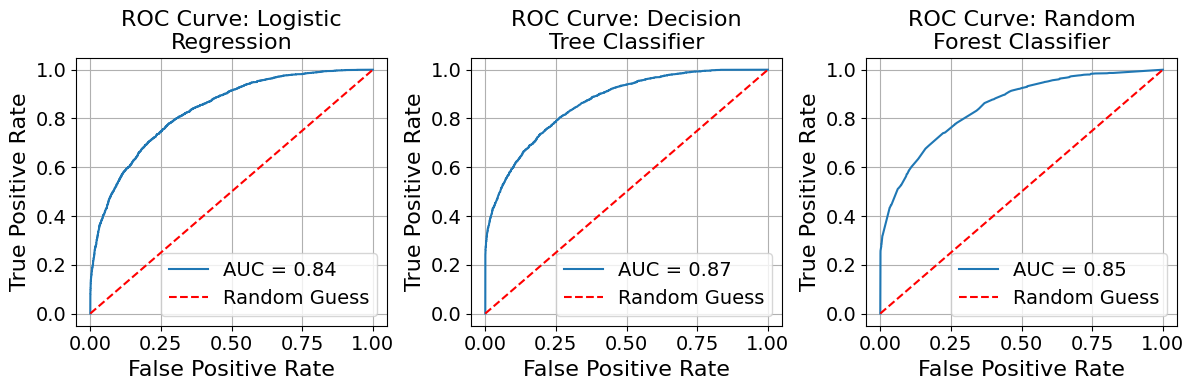

In [10]:
# Plot ROC curves
show_roc_curve(
    models=pipelines_or_models,
    X=X_test,
    y=y_test,
    model_titles=model_titles,
    decimal_places=2,
    n_cols=3,
    n_rows=1,
    # curve_kwgs={
    #     "Logistic Regression": {"color": "blue", "linewidth": 2},
    # },
    linestyle_kwgs={"color": "red", "linestyle": "--"},
    save_plot=True,
    grid=True,
    text_wrap=20,
    figsize=(12, 4),
    label_fontsize=16,
    tick_fontsize=14,
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
)

AUC for Logistic Regression: 0.93


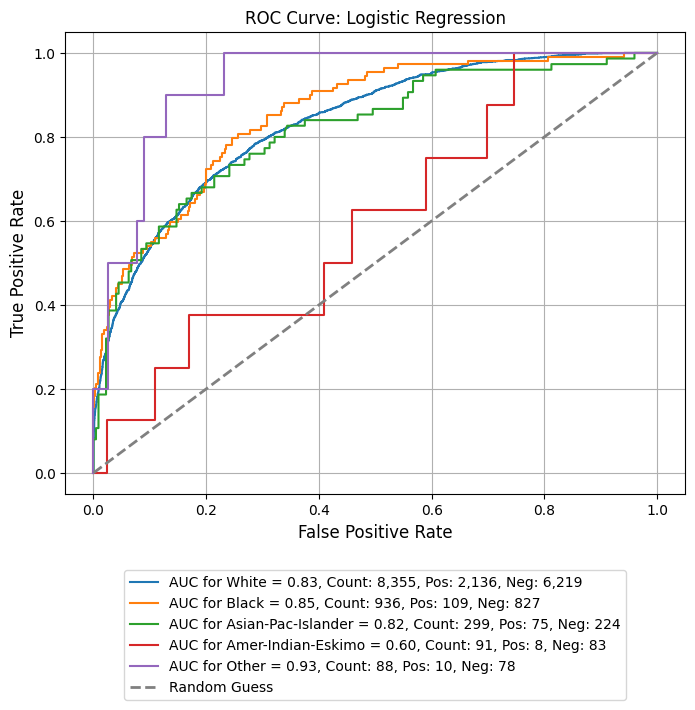

AUC for Decision Tree Classifier: 0.94


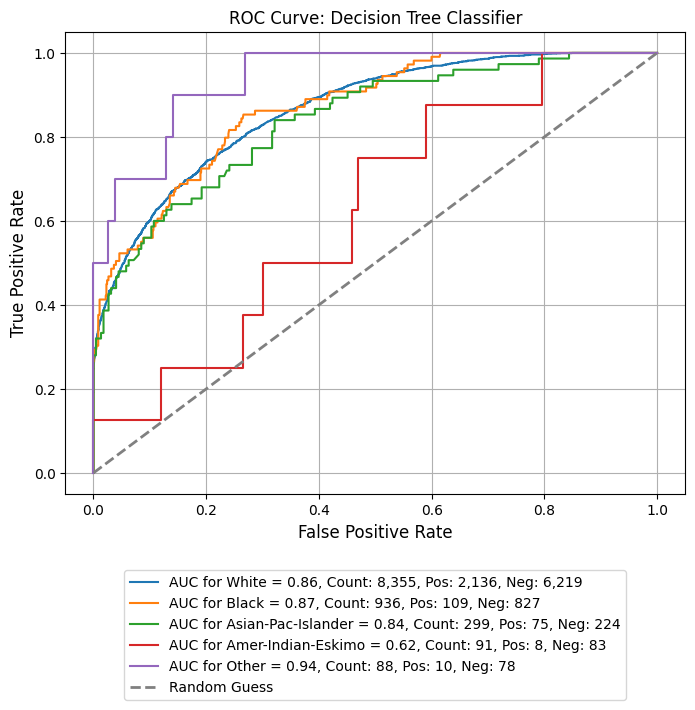

AUC for Random Forest Classifier: 0.92


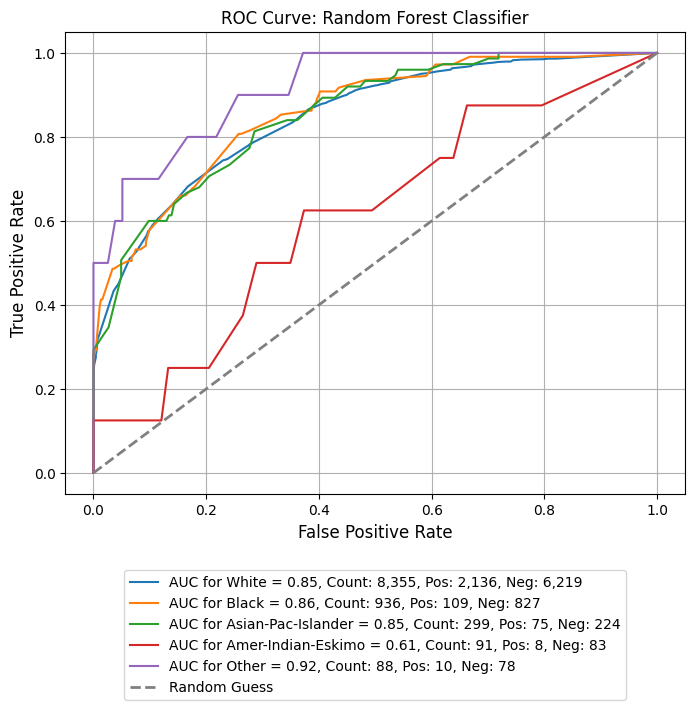

In [11]:
# Plot ROC curves
show_roc_curve(
    models=pipelines_or_models,
    X=X_test,
    y=y_test,
    # overlay=True,
    # title="Custom",
    # title = "",
    title=None,
    model_titles=model_titles,
    decimal_places=2,
    n_cols=3,
    # n_rows=1,
    # curve_kwgs={
    #     "Logistic Regression": {"color": "blue", "linewidth": 2},
    # },
    # linestyle_kwgs={"color": "grey", "linestyle": "--"},
    save_plot=True,
    # grid=True,
    # figsize=(8, 8),
    # label_fontsize=16,
    # tick_fontsize=16,
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
    # gridlines=False,
    group_category=X_test_2["race"],
)

Average Precision for Logistic Regression: 0.63


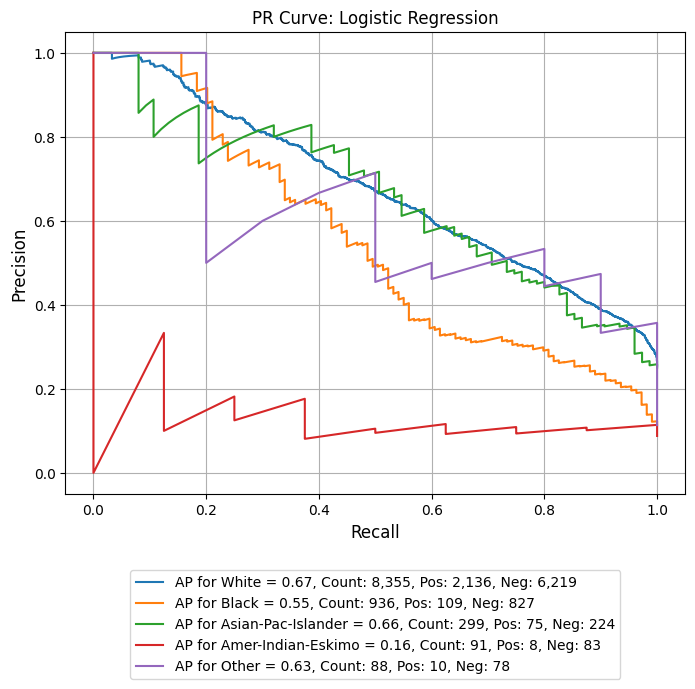

Average Precision for Decision Tree Classifier: 0.77


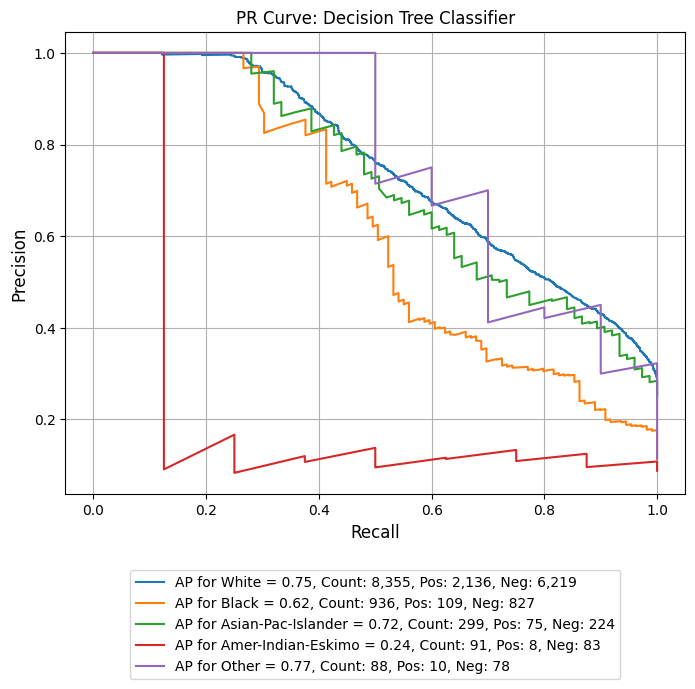

Average Precision for Random Forest Classifier: 0.73


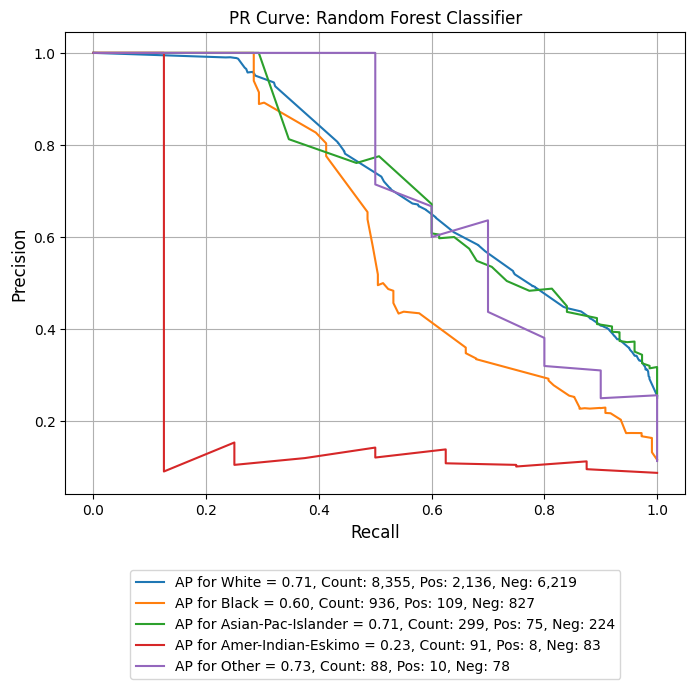

In [12]:
# Plot ROC curves
show_pr_curve(
    models=pipelines_or_models,
    X=X_test,
    y=y_test,
    overlay=False,
    # title="Custom",
    # title = "",
    title=None,
    model_titles=model_titles,
    decimal_places=2,
    n_cols=3,
    # n_rows=1,
    # curve_kwgs={
    #     "Logistic Regression": {"color": "blue", "linewidth": 2},
    # },
    # linestyle_kwgs={"color": "grey", "linestyle": "--"},
    save_plot=True,
    grid=False,
    # figsize=(8, 8),
    # label_fontsize=16,
    # tick_fontsize=16,
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
    # gridlines=False,
    group_category=X_test_2["race"],
)

## Summarize Model Performance

In [13]:
model_summary = summarize_model_performance(
    model=pipelines_or_models,
    X=X_test,
    y=y_test,
    model_titles=model_titles,
    # model_threshold=thresholds,
    return_df=True,
    # decimal_places=6,
    # custom_threshold=0.7,
)

model_summary

,Metrics,Logistic Regression,Decision Tree Classifier,Random Forest Classifier
,Precision/PPV,0.723,0.748,0.712
,Average Precision,0.664,0.736,0.702
,Sensitivity/Recall,0.409,0.5,0.515
,Specificity,0.951,0.947,0.934
,F1-Score,0.522,0.599,0.598
,AUC ROC,0.836,0.866,0.85
,Brier Score,0.127,0.114,0.12
,Model Threshold,0.5,0.5,0.5


In [14]:
model_titles

['Logistic Regression', 'Decision Tree Classifier', 'Random Forest Classifier']

In [15]:
model_titles[1]

'Decision Tree Classifier'

Processing Model: Logistic Regression
Logistic Regression: Kolmogorov-Smirnov Statistic = 0.50, p < 0.01


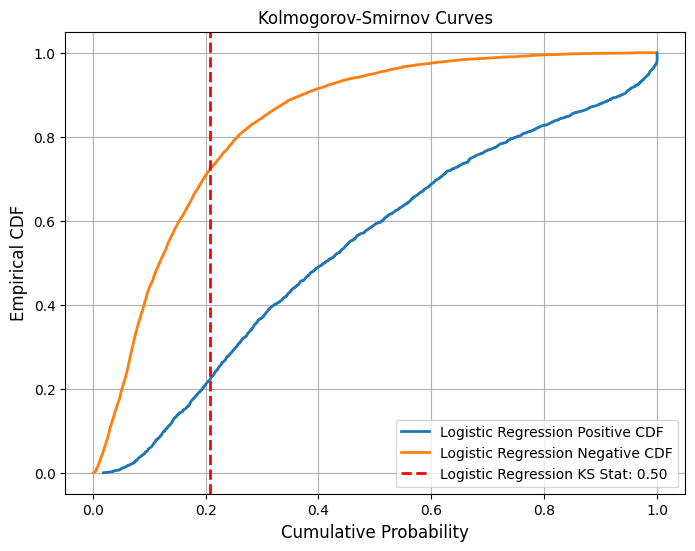

In [18]:
# Example: Running KS Curve with a trained model
show_ks_curve(
    models=pipelines_or_models[0],  # Your trained model object
    X=X_test,  # Test dataset
    y=y_test,  # True labels
    title="Kolmogorov-Smirnov Curves",
    save_plot=False,
    text_wrap=50,
    curve_kwgs={"linewidth": 2},
    linestyle_kwgs={"color": "red", "linestyle": "--", "linewidth": 2},
    figsize=(8, 6),
    label_fontsize=12,
    model_titles=model_titles,
    tick_fontsize=10,
    gridlines=True,
)

## Plot The Calibration Curve

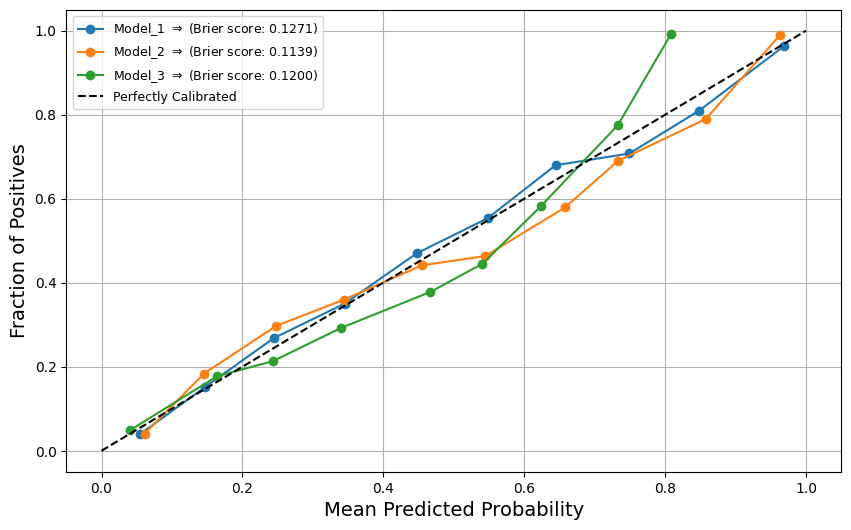

In [19]:
# Plot calibration curves in overlay mode
show_calibration_curve(
    model=pipelines_or_models,
    X=X_test,
    y=y_test,
    # model_titles=model_titles,
    overlay=True,
    # title="Calibration Curves",
    text_wrap=40,
    figsize=(10, 6),
    label_fontsize=14,
    tick_fontsize=9,
    bins=10,
    show_brier_score=True,
    grid=False,
    # gridlines=False,
    linestyle_kwgs={"color": "black"},
    title="",
)

## Plot The Confusion Matrix

Confusion Matrix for Logistic Regression: 

          Predicted 0  Predicted 1
Actual 0         7065          366
Actual 1         1382          956

Classification Report for Logistic Regression: 

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      7431
           1       0.72      0.41      0.52      2338

    accuracy                           0.82      9769
   macro avg       0.78      0.68      0.71      9769
weighted avg       0.81      0.82      0.80      9769

Confusion Matrix for Decision Tree Classifier: 

          Predicted 0  Predicted 1
Actual 0         7038          393
Actual 1         1169         1169

Classification Report for Decision Tree Classifier: 

              precision    recall  f1-score   support

           0       0.86      0.95      0.90      7431
           1       0.75      0.50      0.60      2338

    accuracy                           0.84      9769
   macro avg       0.80      0.72      0.75    

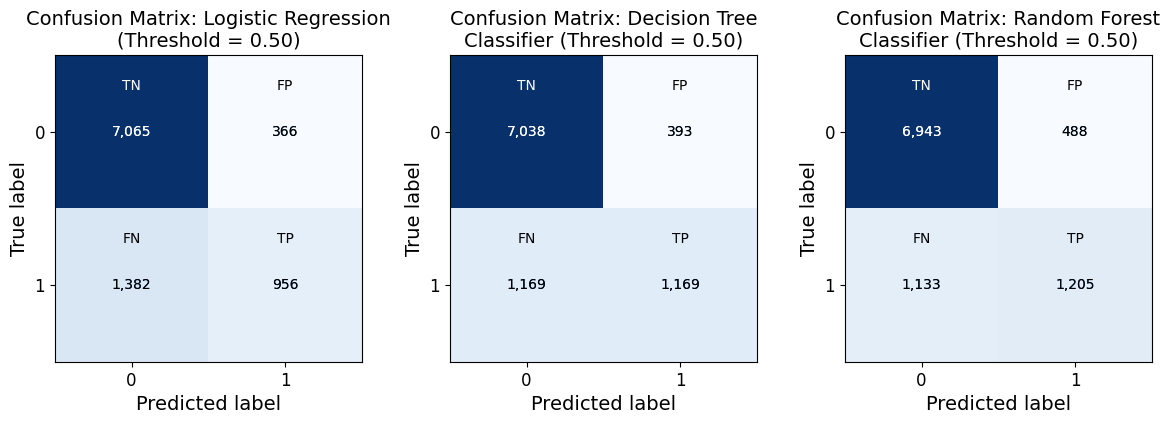

In [20]:
show_confusion_matrix(
    model=pipelines_or_models,
    X=X_test,
    y=y_test,
    model_titles=model_titles,
    cmap="Blues",
    text_wrap=40,
    # title="Custom",
    save_plot=True,
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
    grid=True,
    n_cols=3,
    n_rows=1,
    figsize=(4, 4),
    show_colorbar=False,
    label_fontsize=14,
    tick_fontsize=12,
    inner_fontsize=10,
    class_report=True,
    # custom_threshold=0.5,
    # labels=False,
)

## Plot ROC AUC Curve

AUC for Logistic Regression: 0.930769


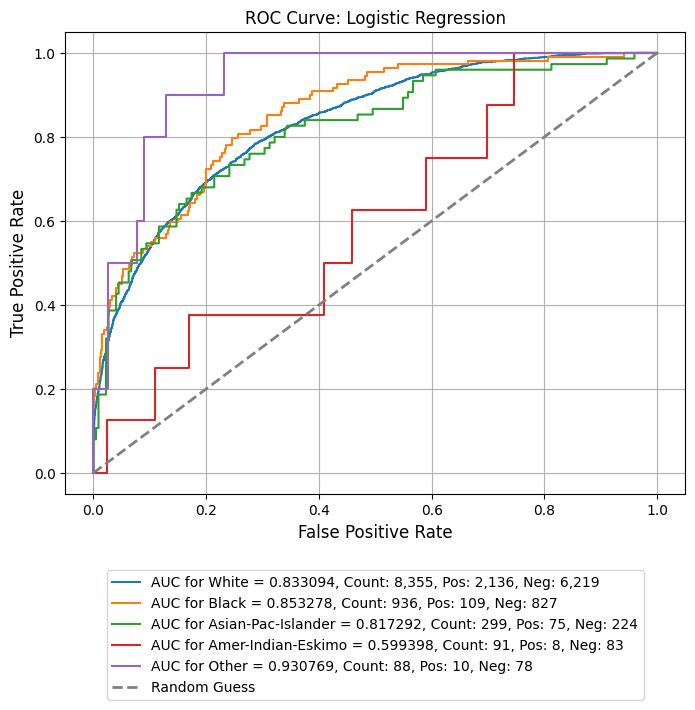

AUC for Decision Tree Classifier: 0.939744


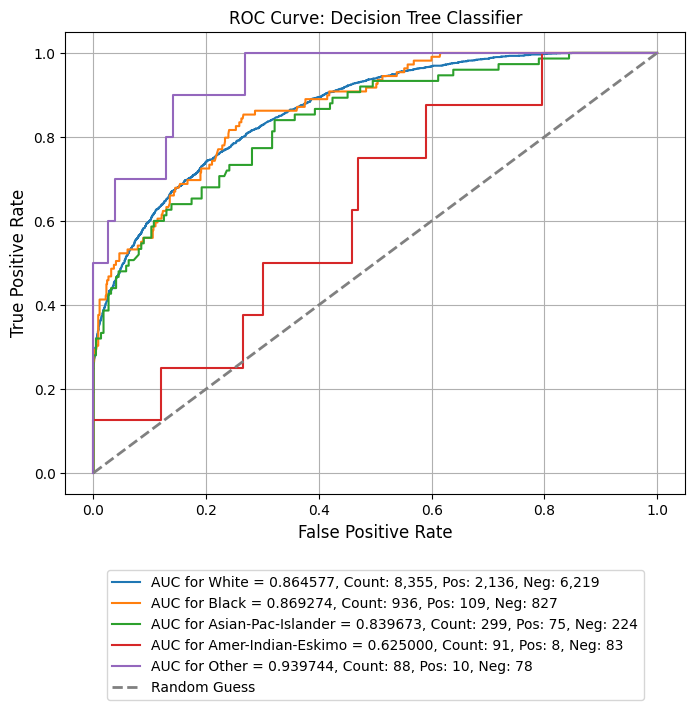

AUC for Random Forest Classifier: 0.917949


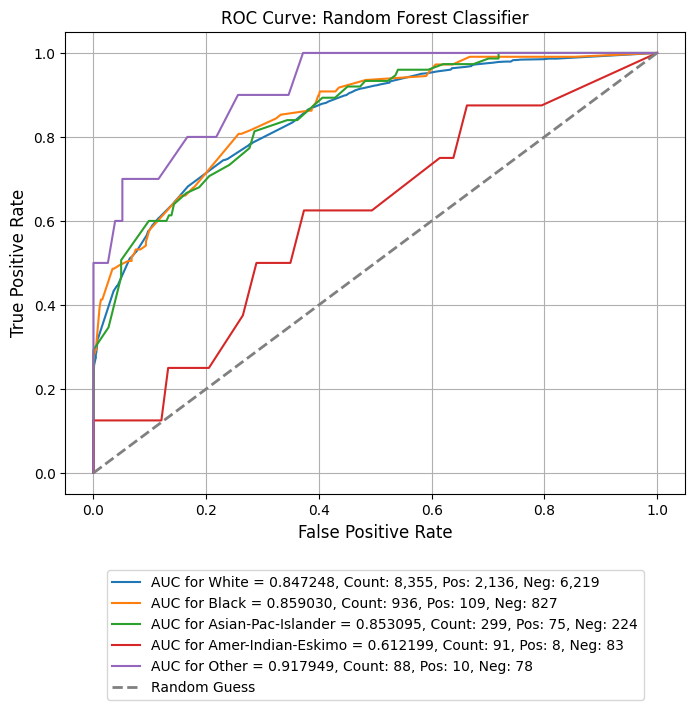

In [21]:
# Plot ROC curves
show_roc_curve(
    models=pipelines_or_models,
    X=X_test,
    y=y_test,
    overlay=False,
    # title="Custom",
    title=None,
    model_titles=model_titles,
    decimal_places=6,
    n_cols=3,
    # n_rows=1,
    # curve_kwgs={
    #     "Logistic Regression": {"color": "blue", "linewidth": 2},
    #     "SVM": {"color": "red", "linestyle": "--", "linewidth": 1.5},
    # },
    # linestyle_kwgs={"color": "grey", "linestyle": "--"},
    save_plot=True,
    grid=False,
    # figsize=(8, 6),
    # label_fontsize=16,
    # tick_fontsize=16,
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
    # gridlines=False,
    group_category=X_test_2["race"],
)

Average Precision for Logistic Regression: 0.635


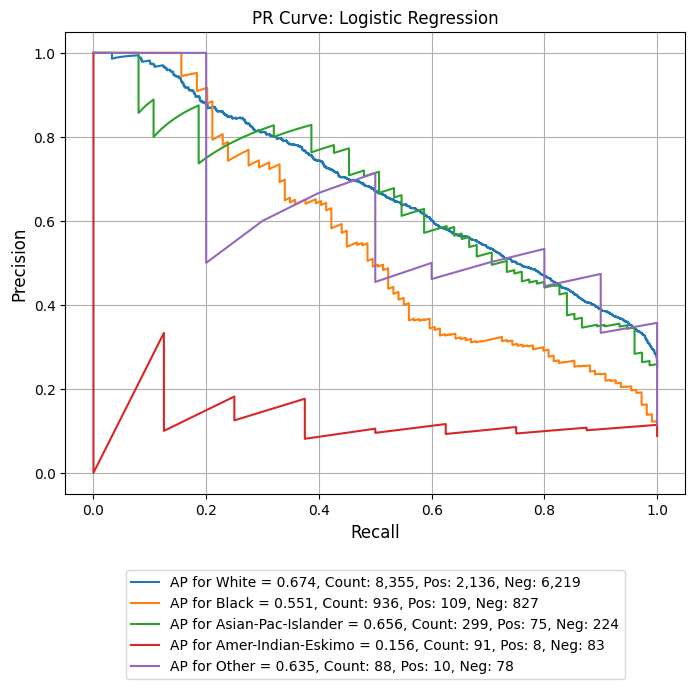

Average Precision for Decision Tree Classifier: 0.767


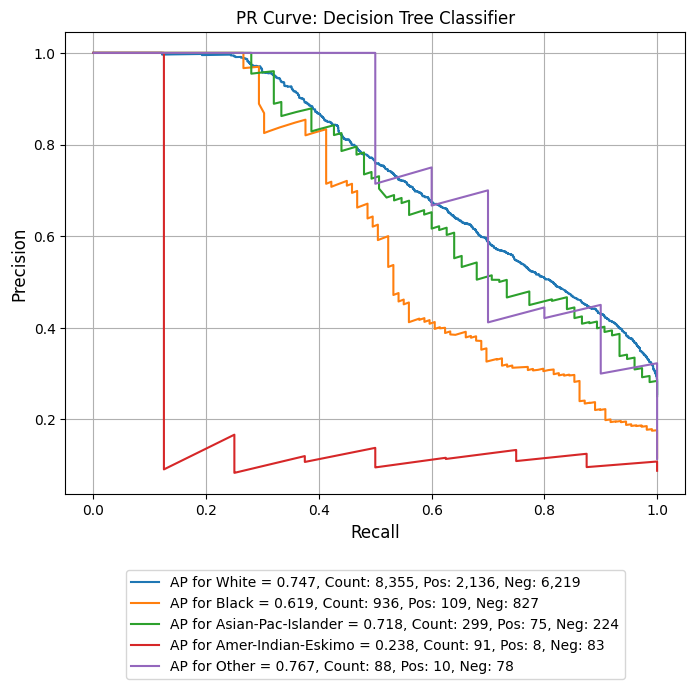

Average Precision for Random Forest Classifier: 0.725


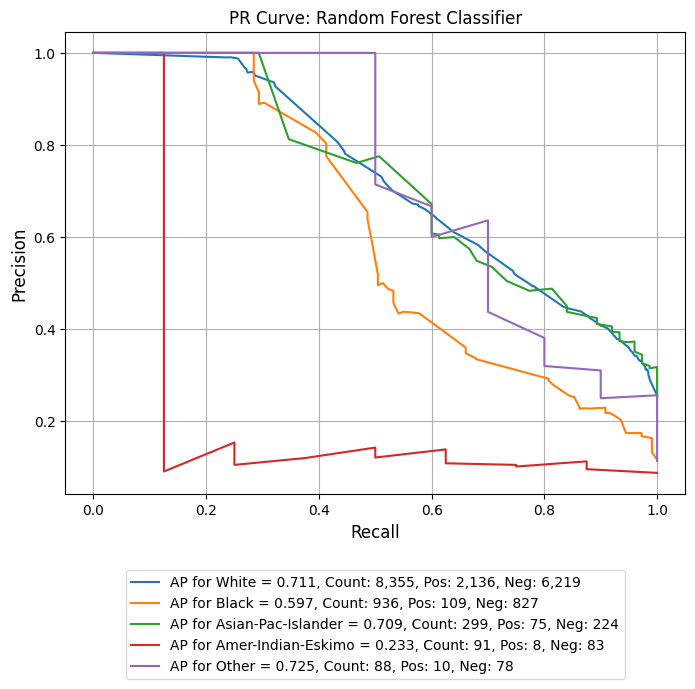

In [22]:
# Plot ROC curves
show_pr_curve(
    models=pipelines_or_models,
    X=X_test,
    y=y_test,
    overlay=False,
    # title="Custom",
    title=None,
    model_titles=model_titles,
    decimal_places=3,
    n_cols=3,
    # n_rows=1,
    # curve_kwgs={
    #     "Logistic Regression": {"color": "blue", "linewidth": 2},
    #     "SVM": {"color": "red", "linestyle": "--", "linewidth": 1.5},
    # },
    # linestyle_kwgs={"color": "grey", "linestyle": "--"},
    save_plot=True,
    grid=False,
    # figsize=(10, 10),
    # label_fontsize=16,
    # tick_fontsize=16,
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
    # gridlines=False,
    group_category=X_test_2["race"],
)

In [23]:
X_test.columns.to_list()

['age',
 'fnlwgt',
 'education-num',
 'capital-gain',
 'capital-loss',
 'hours-per-week']

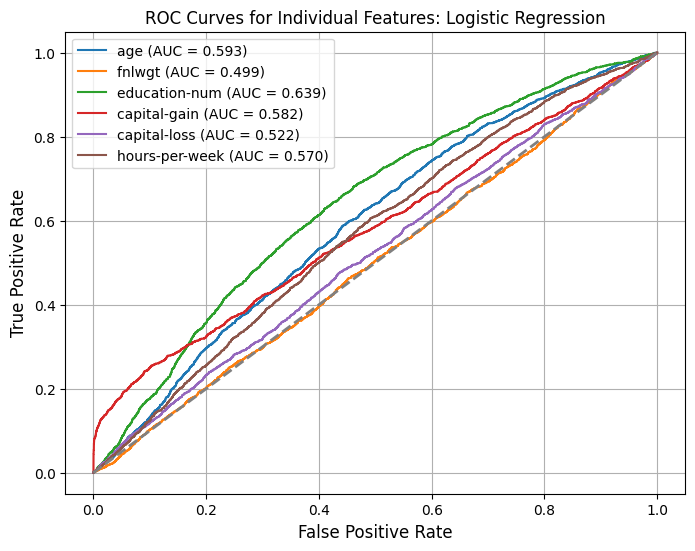

In [24]:
# Call the function
show_feat_roc(
    models=pipelines_or_models[0],
    X=X_test,
    y=y_test,
    feature_names=X_test.columns.to_list(),
    model_titles=model_titles,
    save_plot=False,
    image_path_png=image_path_png,
)

## Precision-Recall Curve

Average Precision for Logistic Regression: 0.664
Average Precision for Decision Tree Classifier: 0.736
Average Precision for Random Forest Classifier: 0.702


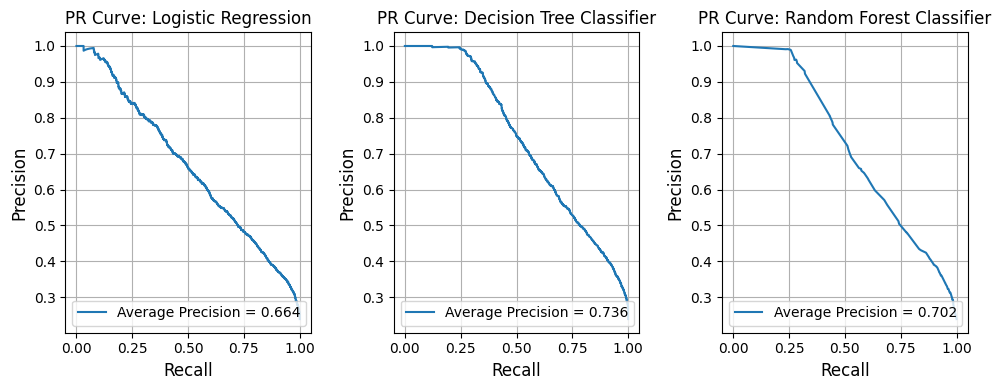

In [25]:
show_pr_curve(
    models=pipelines_or_models,
    X=X_test,
    y=y_test,
    # x_label="Hello",
    model_titles=model_titles,
    decimal_places=3,
    # title="Custom",
    overlay=False,
    n_cols=3,
    grid=True,
    save_plot=True,
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
    figsize=(10, 4),
    # tick_fontsize=16,
    # label_fontsize=16,
    # grid=True,
    # gridlines=False,
)

## Lift Chart

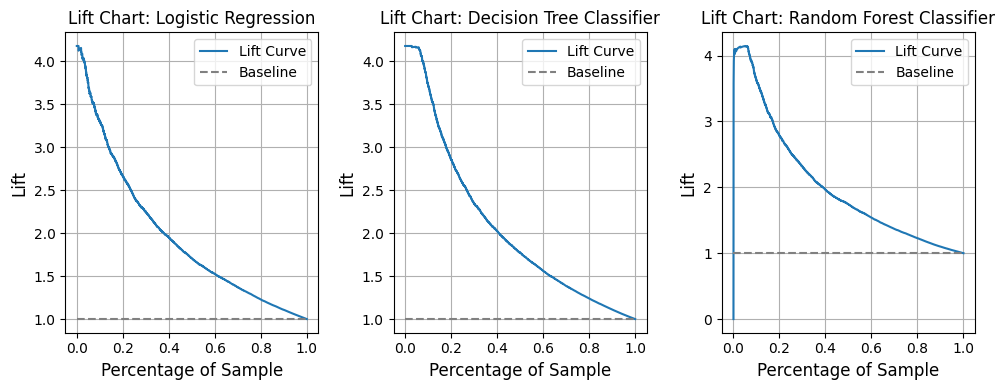

In [26]:
# Plot Lift chart
show_lift_chart(
    models=pipelines_or_models,
    X=X_test,
    y=y_test,
    overlay=False,
    # title="Custom",
    model_titles=model_titles,
    save_plot=True,
    # curve_kwgs={
    #     "Logistic Regression": {"color": "blue", "linewidth": 2},
    #     # "SVM": {"color": "red", "linestyle": "--", "linewidth": 1.5},
    # },
    linestyle_kwgs={"color": "grey", "linestyle": "--"},
    grid=True,
    n_cols=3,
    figsize=(10, 4),
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
)

## Gain Chart

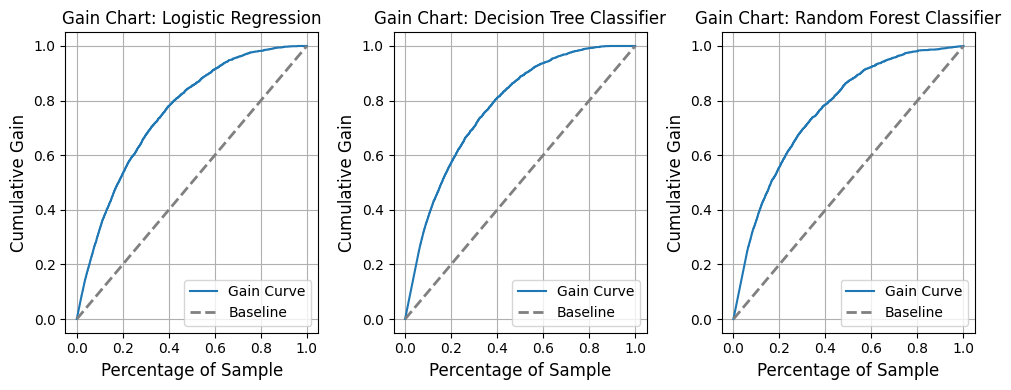

In [27]:
# Plot Gain chart
show_gain_chart(
    models=pipelines_or_models,
    X=X_test,
    y=y_test,
    overlay=False,
    # title="Custom",
    model_titles=model_titles,
    # curve_kwgs={
    #     "Logistic Regression": {"color": "blue", "linewidth": 2},
    #     # "SVM": {"color": "red", "linestyle": "--", "linewidth": 1.5},
    # },
    # linestyle_kwgs={"color": "black", "linestyle": "-"},
    save_plot=True,
    grid=True,
    n_cols=3,
    figsize=(10, 4),
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
)

In [28]:
model_summary = summarize_model_performance(
    model=pipelines_or_models[0],
    X=X_test,
    y=y_test,
    model_titles=model_titles,
    # model_threshold=thresholds,
    return_df=True,
    custom_threshold=0.7811,
)

model_summary

,Metrics,Logistic Regression
,Precision/PPV,0.898
,Average Precision,0.664
,Sensitivity/Recall,0.184
,Specificity,0.993
,F1-Score,0.306
,AUC ROC,0.836
,Brier Score,0.127
,Model Threshold,0.781


Best threshold for precision = 0.879 is: 0.7619


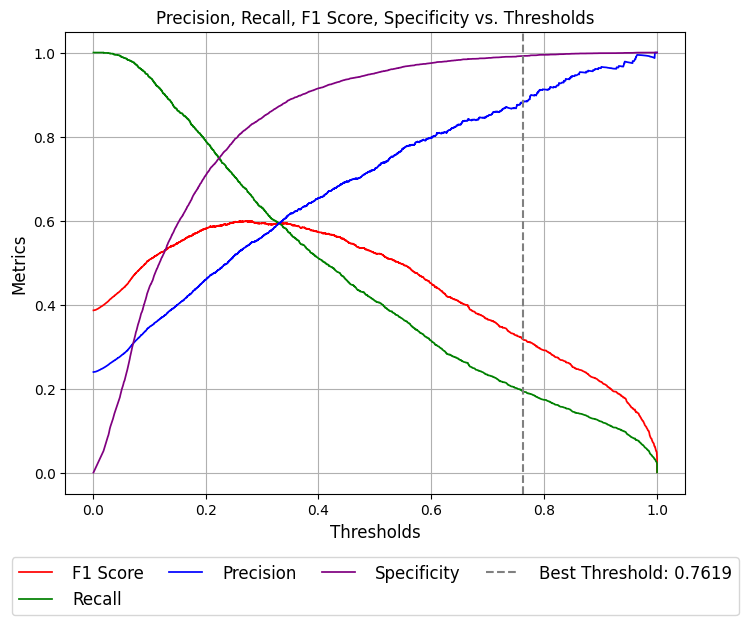

In [29]:
# Example usage with a trained model
plot_threshold_metrics(
    pipelines_or_models[0],
    X_test,
    y_test,
    # figsize=(6, 6),
    # gridlines=False,
    baseline_thresh=False,
    baseline_kwgs={
        "color": "purple",
        "linestyle": "--",
        # "alpha": 0.7,
        "linewidth": 1,
    },
    curve_kwgs={
        "linestyle": "-",
        # "alpha": 0.1,
        "linewidth": 1.25,
    },
    lookup_metric="precision",
    lookup_value=0.879,
    # title="Threshold Metrics for Model X",
    # decimal_places=2,
    # label_fontsize=10,
    # tick_fontsize=8,
)